In [ ]:
import cv2
import numpy as np
import gradio as gr
from sklearn.cluster import KMeans
from skimage.feature import graycomatrix, graycoprops
from scipy import ndimage
from PIL import Image

# =========================================================
# EDGE MAGNITUDE & ORIENTATION
# =========================================================
def compute_edge_features(gray):
    gx = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=3)

    mag = cv2.magnitude(gx, gy)
    ang = cv2.phase(gx, gy, angleInDegrees=True)

    mag = cv2.normalize(mag, None, 0, 1, cv2.NORM_MINMAX)
    ang = ang / 180.0

    return mag, ang

# =========================================================
# GLCM TEXTURE FEATURES
# =========================================================
def glcm_texture_features(gray):
    glcm = graycomatrix(
        gray,
        distances=[1],
        angles=[0],
        levels=256,
        symmetric=True,
        normed=True
    )

    contrast = graycoprops(glcm, 'contrast')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]

    return contrast, homogeneity, energy

# =========================================================
# SEGMENTATION USING K-MEANS
# =========================================================
def segment_weapon(img):
    h, w = img.shape[:2]

    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    edge_mag, edge_ang = compute_edge_features(gray)
    contrast, homogeneity, energy = glcm_texture_features(gray)

    tex_map = np.ones((h, w, 3), dtype=np.float32)
    tex_map[..., 0] *= contrast
    tex_map[..., 1] *= homogeneity
    tex_map[..., 2] *= energy

    features = np.concatenate([
        img / 255.0,
        hsv / 255.0,
        lab / 255.0,
        edge_mag[..., None],
        edge_ang[..., None],
        tex_map
    ], axis=2)

    X = features.reshape(-1, features.shape[2])

    kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)

    return labels.reshape(h, w), edge_mag

# =========================================================
# SELECT WEAPON CLUSTER
# =========================================================
def select_weapon_cluster(segmented, gray, edge_mag):
    best_cluster = None
    best_score = -1

    for c in np.unique(segmented):
        mask = segmented == c
        mean_intensity = np.mean(gray[mask])
        edge_strength = np.mean(edge_mag[mask])
        area = np.sum(mask)

        score = edge_strength * area / (mean_intensity + 1e-5)

        if score > best_score:
            best_score = score
            best_cluster = c

    return best_cluster

# =========================================================
# MASK CLEANING
# =========================================================
def refine_mask(mask):
    kernel = np.ones((19, 19), np.uint8)

    mask = ndimage.binary_fill_holes(mask).astype(np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    return mask

# =========================================================
# OVERLAY + BOUNDING BOX
# =========================================================
def create_overlay(img, mask):
    overlay = img.copy()
    overlay[mask == 1] = (0, 255, 0)

    contours, _ = cv2.findContours(
        mask.astype(np.uint8),
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE
    )

    if contours:
        x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
        cv2.rectangle(overlay, (x, y), (x + w, y + h), (255, 0, 0), 3)

    return overlay

# =========================================================
# EXTRACT WEAPON ON WHITE BACKGROUND
# =========================================================
def extract_on_white(img, mask):
    white_bg = np.ones_like(img) * 255
    return np.where(mask[..., None] == 1, img, white_bg)

# =========================================================
# MAIN GRADIO APP FUNCTION
# =========================================================
def weapon_segmentation_app(image):
    img = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    segmented, edge_mag = segment_weapon(img)
    weapon_cluster = select_weapon_cluster(segmented, gray, edge_mag)

    mask = refine_mask((segmented == weapon_cluster).astype(np.uint8))
    overlay = create_overlay(img, mask)
    extracted = extract_on_white(img, mask)

    return (
        cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB),
        cv2.cvtColor(extracted, cv2.COLOR_BGR2RGB)
    )

# =========================================================
# GRADIO INTERFACE
# =========================================================
gr.Interface(
    fn=weapon_segmentation_app,
    inputs=gr.Image(type="pil", label="Upload Image"),
    outputs=[
        gr.Image(label="Detected Weapon Overlay"),
        gr.Image(label="Extracted Weapon (White Background)")
    ],
    title="DIP Semester Project (Weapon Segmentation using unsupervised learning)",
    description="Weapon Segmentation"
).launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://00f395ffebe4b058de.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# **Best Working Model - Color, Edges and GLCM**

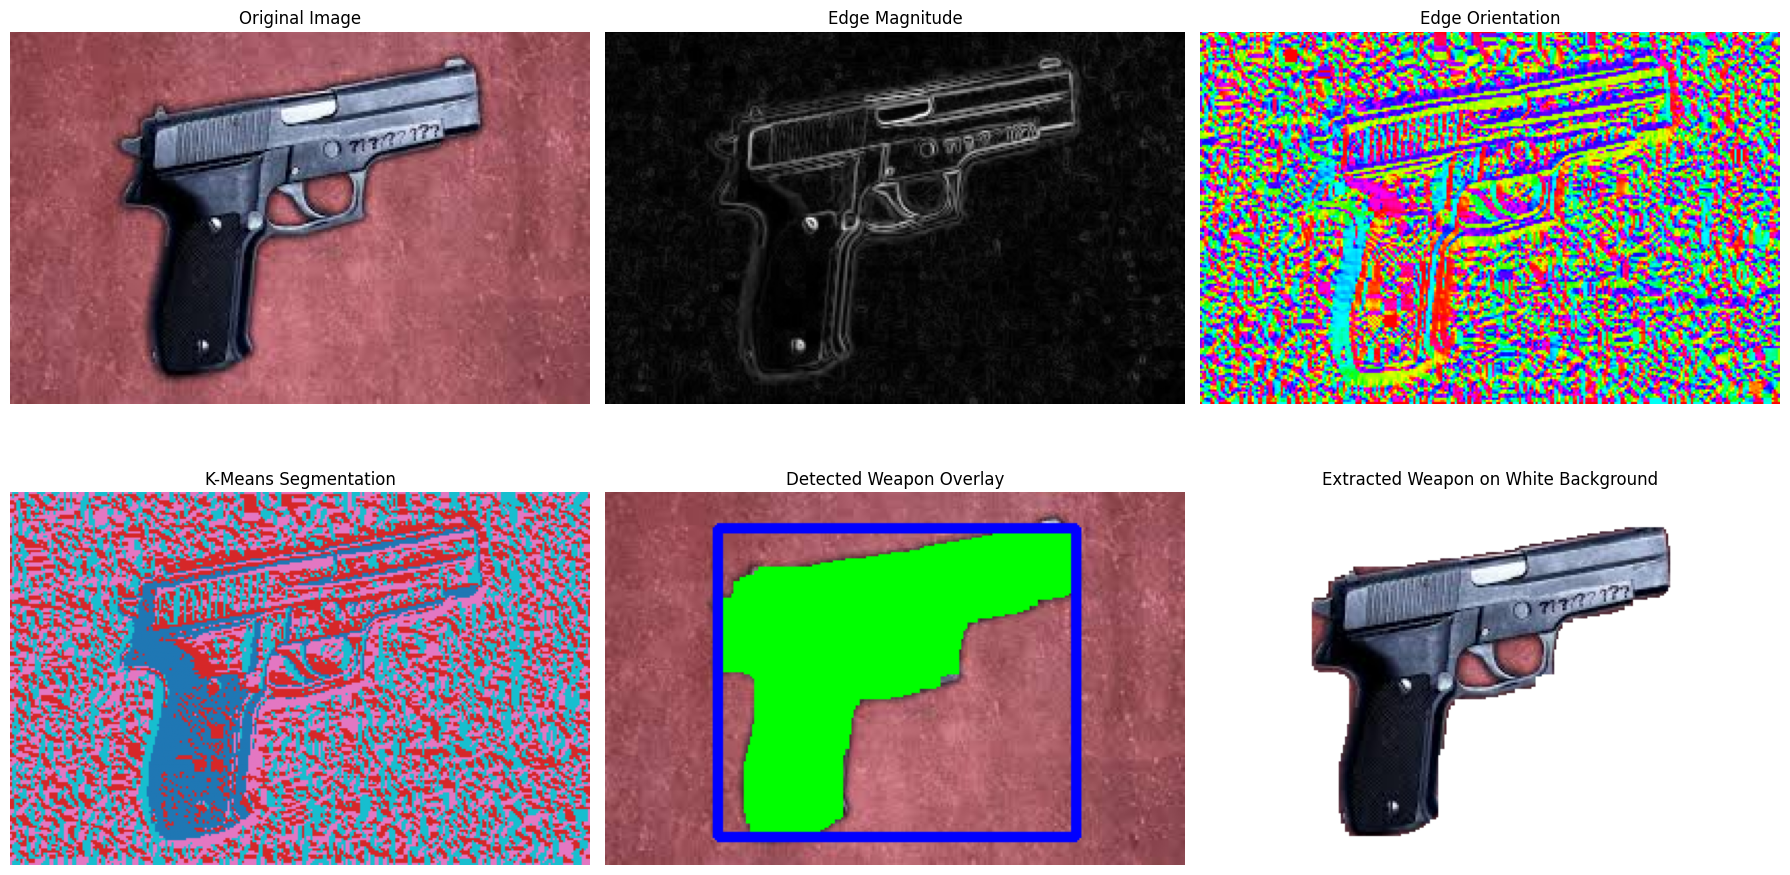

✅ Collage saved at: /content/drive/MyDrive/dip_project_results/weapon_detection_collage1.png


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage.feature import graycomatrix, graycoprops
from scipy import ndimage
import os

# ---------------------------------------------------------
# CONFIG
# ---------------------------------------------------------
K_CLUSTERS = 4
SAVE_DIR = "/content/drive/MyDrive/dip_project_results"

# Create folder if not exists
os.makedirs(SAVE_DIR, exist_ok=True)

# ---------------------------------------------------------
# EDGE MAGNITUDE & ORIENTATION (SOBEL)
# ---------------------------------------------------------
def compute_edge_features(gray):

    gx = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=3)

    magnitude = cv2.magnitude(gx, gy)
    angle = cv2.phase(gx, gy, angleInDegrees=True)

    magnitude = cv2.normalize(magnitude, None, 0, 1, cv2.NORM_MINMAX)
    angle = angle / 180.0

    return magnitude, angle

# ---------------------------------------------------------
# GLCM TEXTURE FEATURES (GLOBAL)
# ---------------------------------------------------------
def glcm_texture_features(gray):

    glcm = graycomatrix(
        gray,
        distances=[1],
        angles=[0],
        levels=256,
        symmetric=True,
        normed=True
    )

    contrast = graycoprops(glcm, 'contrast')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]

    return contrast, homogeneity, energy

# ---------------------------------------------------------
# SEGMENTATION USING K-MEANS
# ---------------------------------------------------------
def segment_weapon(img_bgr):

    img = img_bgr.copy()
    h, w = img.shape[:2]

    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    edge_mag, edge_angle = compute_edge_features(gray)

    contrast, homogeneity, energy = glcm_texture_features(gray)

    tex_map = np.ones((h, w, 3), dtype=np.float32)
    tex_map[..., 0] *= contrast
    tex_map[..., 1] *= homogeneity
    tex_map[..., 2] *= energy

    features = np.concatenate([
        img / 255.0,
        hsv / 255.0,
        lab / 255.0,
        edge_mag[..., None],
        edge_angle[..., None],
        tex_map
    ], axis=2)

    X = features.reshape(-1, features.shape[2])

    kmeans = KMeans(n_clusters=K_CLUSTERS, random_state=42)
    labels = kmeans.fit_predict(X)

    return labels.reshape(h, w), edge_mag, edge_angle

# ---------------------------------------------------------
# SELECT WEAPON CLUSTER
# ---------------------------------------------------------
def select_weapon_cluster(segmented, gray, edge_mag):

    best_cluster = None
    best_score = -1

    for c in np.unique(segmented):
        mask = segmented == c
        mean_intensity = np.mean(gray[mask])
        edge_strength = np.mean(edge_mag[mask])
        area = np.sum(mask)

        score = edge_strength * area / (mean_intensity + 1e-5)

        if score > best_score:
            best_score = score
            best_cluster = c

    return best_cluster

# ---------------------------------------------------------
# MASK CLEANING
# ---------------------------------------------------------
def refine_mask(mask):

    kernel = np.ones((19, 19), np.uint8)

    mask = ndimage.binary_fill_holes(mask).astype(np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    return mask

# ---------------------------------------------------------
# OVERLAY + BOUNDING BOX
# ---------------------------------------------------------
def create_overlay(img, mask):

    overlay = img.copy()
    overlay[mask == 1] = (0, 255, 0)

    contours, _ = cv2.findContours(mask.astype(np.uint8),
                                   cv2.RETR_EXTERNAL,
                                   cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
        cv2.rectangle(overlay, (x, y), (x+w, y+h), (255, 0, 0), 3)

    return overlay

# ---------------------------------------------------------
# EXTRACT WEAPON ON WHITE BACKGROUND
# ---------------------------------------------------------
def extract_on_white(img, mask):
    white_bg = np.ones_like(img) * 255
    return np.where(mask[..., None] == 1, img, white_bg)


# ---------------------------------------------------------
# MAIN
# ---------------------------------------------------------
img = cv2.imread("/content/drive/MyDrive/DIP Project/images (3).jfif")

if img is None:
    raise ValueError("Image path incorrect")

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

segmented, edge_mag, edge_angle = segment_weapon(img)
weapon_cluster = select_weapon_cluster(segmented, gray, edge_mag)

mask = refine_mask((segmented == weapon_cluster).astype(np.uint8))
overlay = create_overlay(img, mask)

white_result = extract_on_white(img, mask)


fig = plt.figure(figsize=(18, 10))

plt.subplot(2, 3, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

plt.subplot(2, 3, 2)
plt.imshow(edge_mag, cmap="gray")
plt.title("Edge Magnitude")
plt.axis("off")

plt.subplot(2, 3, 3)
plt.imshow(edge_angle, cmap="hsv")
plt.title("Edge Orientation")
plt.axis("off")

plt.subplot(2, 3, 4)
plt.imshow(segmented, cmap="tab10")
plt.title("K-Means Segmentation")
plt.axis("off")

plt.subplot(2, 3, 5)
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.title("Detected Weapon Overlay")
plt.axis("off")

plt.subplot(2, 3, 6)
plt.imshow(cv2.cvtColor(white_result, cv2.COLOR_BGR2RGB))
plt.title("Extracted Weapon on White Background")
plt.axis("off")

plt.tight_layout()
plt.show()

plt.tight_layout()


save_path = os.path.join(SAVE_DIR, "weapon_detection_collage3.png")
plt.savefig(save_path, dpi=300)
plt.show()

print(f"✅ Collage saved at: {save_path}")


# **Using Edge And Color**

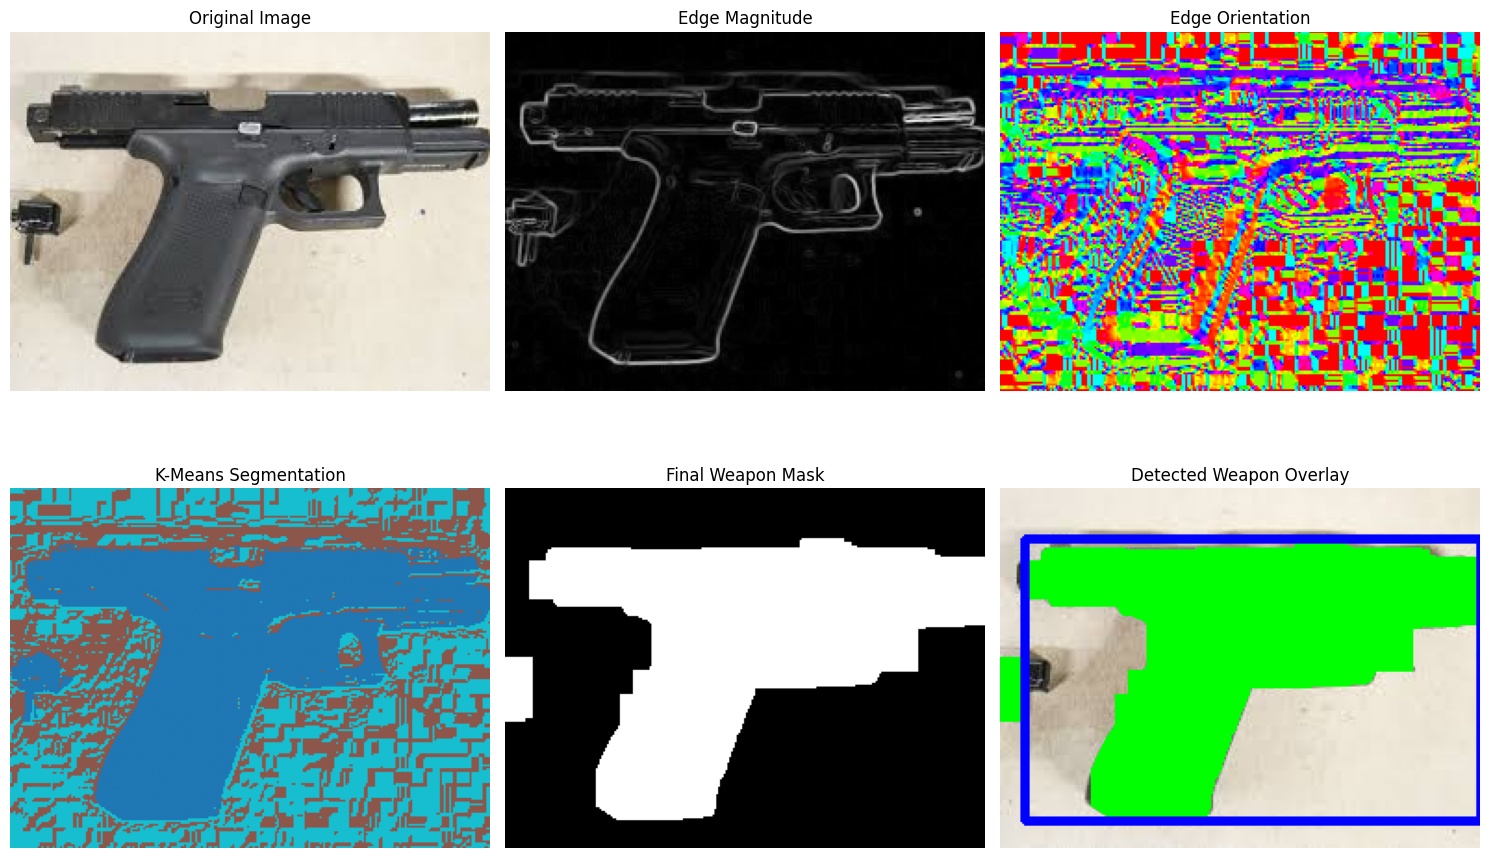

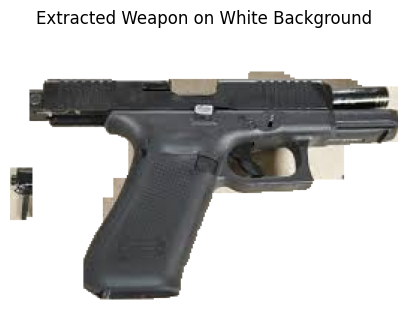

In [ ]:
# =========================================================
# HYBRID WEAPON SEGMENTATION
# (Color + HSV + Edge Magnitude + Edge Angle)
# =========================================================

import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy import ndimage

# ---------------------------------------------------------
# CONFIG
# ---------------------------------------------------------
K_CLUSTERS = 3

# ---------------------------------------------------------
# EDGE MAGNITUDE & ANGLE (SOBEL)
# ---------------------------------------------------------
def compute_edge_features(gray):

    gx = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=3)

    magnitude = cv2.magnitude(gx, gy)
    angle = cv2.phase(gx, gy, angleInDegrees=True)

    magnitude = cv2.normalize(magnitude, None, 0, 1, cv2.NORM_MINMAX)
    angle = angle / 180.0

    return magnitude, angle

# ---------------------------------------------------------
# SEGMENTATION USING K-MEANS (NO GLCM)
# ---------------------------------------------------------
def segment_weapon(img_bgr):

    img = img_bgr.copy()
    h, w = img.shape[:2]

    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    edge_mag, edge_angle = compute_edge_features(gray)

    # -------- FEATURE VECTOR --------
    features = np.concatenate([
        img / 255.0,              # RGB (3)
        hsv / 255.0,              # HSV (3)
        edge_mag[..., None],      # Edge magnitude (1)
        edge_angle[..., None]     # Edge angle (1)
    ], axis=2)

    X = features.reshape(-1, features.shape[2])

    kmeans = KMeans(n_clusters=K_CLUSTERS, random_state=42)
    labels = kmeans.fit_predict(X)

    return labels.reshape(h, w), edge_mag, edge_angle

# ---------------------------------------------------------
# SELECT WEAPON CLUSTER (EDGE + ANGLE LOGIC)
# ---------------------------------------------------------
def select_weapon_cluster(segmented, edge_mag, edge_angle):

    best_cluster = None
    best_score = -1

    for c in np.unique(segmented):
        mask = segmented == c

        mag_score = np.mean(edge_mag[mask])
        angle_std = np.std(edge_angle[mask])

        score = mag_score / (angle_std + 1e-5)

        if score > best_score:
            best_score = score
            best_cluster = c

    return best_cluster

# ---------------------------------------------------------
# MASK REFINEMENT
# ---------------------------------------------------------
def refine_mask(mask):

    kernel = np.ones((21, 21), np.uint8)

    mask = ndimage.binary_fill_holes(mask).astype(np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    return mask

# ---------------------------------------------------------
# EXTRACT ON WHITE BACKGROUND
# ---------------------------------------------------------
def extract_on_white(img, mask):

    white = np.ones_like(img) * 255
    return np.where(mask[..., None] == 1, img, white)

# ---------------------------------------------------------
# OVERLAY WITH BOUNDING BOX
# ---------------------------------------------------------
def create_overlay(img, mask):

    overlay = img.copy()
    overlay[mask == 1] = (0, 255, 0)

    contours, _ = cv2.findContours(mask.astype(np.uint8),
                                   cv2.RETR_EXTERNAL,
                                   cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
        cv2.rectangle(overlay, (x, y), (x+w, y+h), (255, 0, 0), 3)

    return overlay

# ---------------------------------------------------------
# MAIN
# ---------------------------------------------------------
img = cv2.imread("/content/drive/MyDrive/DIP Project/images (3).jfif")

if img is None:
    raise ValueError("Image path incorrect")

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

segmented, edge_mag, edge_angle = segment_weapon(img)
weapon_cluster = select_weapon_cluster(segmented, edge_mag, edge_angle)

mask = refine_mask((segmented == weapon_cluster).astype(np.uint8))

overlay = create_overlay(img, mask)
white_result = extract_on_white(img, mask)

# ---------------------------------------------------------
# DISPLAY RESULTS
# ---------------------------------------------------------
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

plt.subplot(2, 3, 2)
plt.imshow(edge_mag, cmap="gray")
plt.title("Edge Magnitude")
plt.axis("off")

plt.subplot(2, 3, 3)
plt.imshow(edge_angle, cmap="hsv")
plt.title("Edge Orientation")
plt.axis("off")

plt.subplot(2, 3, 4)
plt.imshow(segmented, cmap="tab10")
plt.title("K-Means Segmentation")
plt.axis("off")

plt.subplot(2, 3, 5)
plt.imshow(mask, cmap="gray")
plt.title("Final Weapon Mask")
plt.axis("off")

plt.subplot(2, 3, 6)
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.title("Detected Weapon Overlay")
plt.axis("off")

plt.tight_layout()
plt.show()

plt.figure(figsize=(5,5))
plt.imshow(cv2.cvtColor(white_result, cv2.COLOR_BGR2RGB))
plt.title("Extracted Weapon on White Background")
plt.axis("off")
plt.show()


# **Segmentation Using Color**

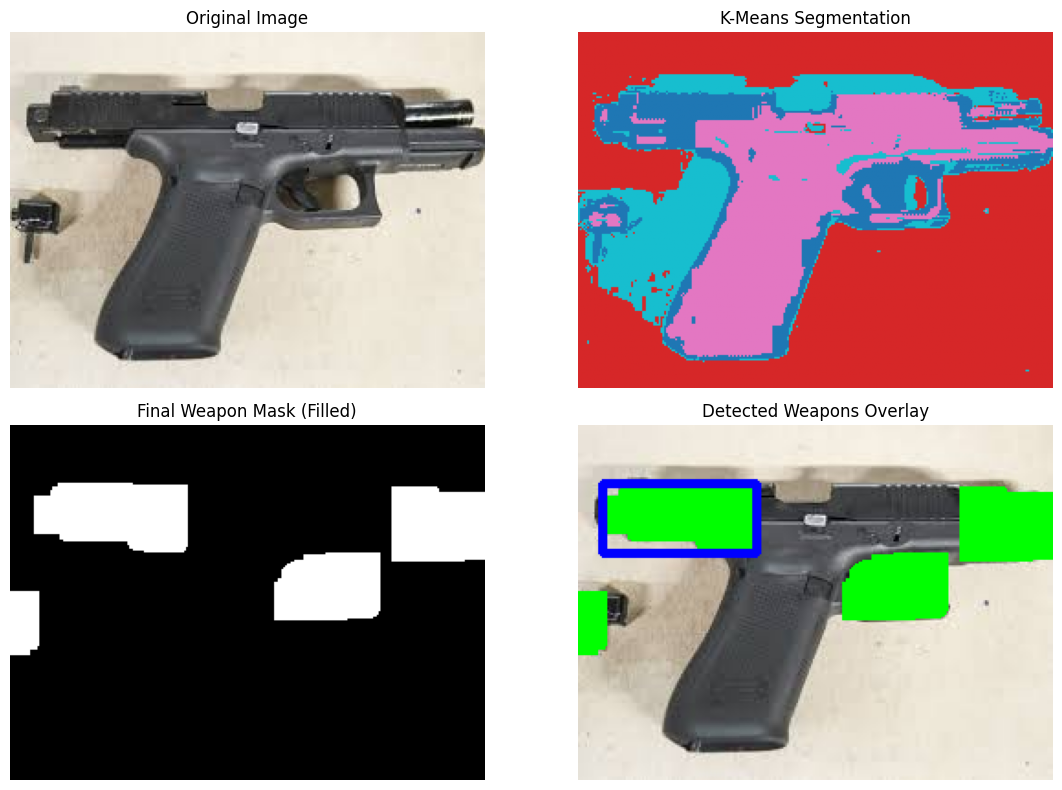

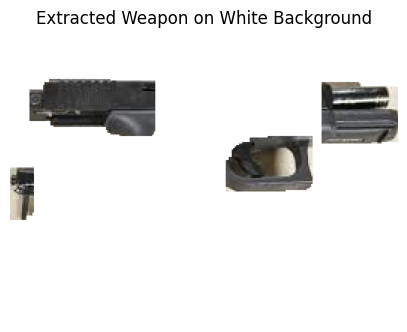

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy import ndimage

# ---------------------------------------------------------
# CONFIG
# ---------------------------------------------------------
K_CLUSTERS = 4

# ---------------------------------------------------------
# SEGMENTATION USING K-MEANS (NO EDGE DOMINANCE)
# ---------------------------------------------------------
def segment_weapon(img_bgr, k_clusters=K_CLUSTERS):

    img = img_bgr.copy()
    h, w = img.shape[:2]

    # Convert color spaces
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Feature vector: COLOR + INTENSITY (NO EDGES)
    features = np.concatenate([
        img / 255.0,
        hsv / 255.0,
        gray.reshape(h, w, 1) / 255.0
    ], axis=2)

    X = features.reshape(-1, features.shape[2])

    kmeans = KMeans(n_clusters=k_clusters, random_state=42)
    labels = kmeans.fit_predict(X)

    return labels.reshape(h, w)

# ---------------------------------------------------------
# SELECT WEAPON CLUSTER (DARK OBJECT HEURISTIC)
# ---------------------------------------------------------
def select_weapon_cluster(segmented, gray):

    clusters = np.unique(segmented)
    scores = []

    for c in clusters:
        mask = (segmented == c)
        mean_intensity = gray[mask].mean()
        area = mask.sum()
        scores.append((c, mean_intensity, area))

    # Weapon is usually DARKER and LARGE
    scores.sort(key=lambda x: (x[1], -x[2]))
    return scores[0][0]

# ---------------------------------------------------------
# CLEAN & FILL MASK (IMPORTANT)
# ---------------------------------------------------------
def refine_mask(mask):

    kernel = np.ones((21, 21), np.uint8)

    # Fill holes
    filled = ndimage.binary_fill_holes(mask).astype(np.uint8)

    # Morphological cleanup
    filled = cv2.morphologyEx(filled, cv2.MORPH_CLOSE, kernel)
    filled = cv2.morphologyEx(filled, cv2.MORPH_OPEN, kernel)

    return filled

# ---------------------------------------------------------
# EXTRACT WEAPON ON WHITE BACKGROUND
# ---------------------------------------------------------
def extract_on_white(img, mask):

    white_bg = np.ones_like(img) * 255
    result = np.where(mask[..., None] == 1, img, white_bg)
    return result

# ---------------------------------------------------------
# DRAW OVERLAY + BOUNDING BOX
# ---------------------------------------------------------
def draw_overlay(img, mask):

    overlay = img.copy()
    overlay[mask == 1] = (0, 255, 0)

    contours, _ = cv2.findContours(mask.astype(np.uint8),
                                   cv2.RETR_EXTERNAL,
                                   cv2.CHAIN_APPROX_SIMPLE)

    x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
    cv2.rectangle(overlay, (x, y), (x+w, y+h), (255, 0, 0), 3)

    return overlay

# ---------------------------------------------------------
# MAIN
# ---------------------------------------------------------
img = cv2.imread("/content/drive/MyDrive/DIP Project/images (3).jfif")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

seg = segment_weapon(img)

weapon_cluster = select_weapon_cluster(seg, gray)

mask = (seg == weapon_cluster).astype(np.uint8)
mask = refine_mask(mask)

white_result = extract_on_white(img, mask)
overlay = draw_overlay(img, mask)

# ---------------------------------------------------------
# DISPLAY RESULTS
# ---------------------------------------------------------
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(seg, cmap="tab10")
plt.title("K-Means Segmentation")
plt.axis("off")

plt.subplot(2, 2, 3)
plt.imshow(mask, cmap="gray")
plt.title("Final Weapon Mask (Filled)")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.title("Detected Weapons Overlay")
plt.axis("off")

plt.tight_layout()
plt.show()

plt.figure(figsize=(5,5))
plt.imshow(cv2.cvtColor(white_result, cv2.COLOR_BGR2RGB))
plt.title("Extracted Weapon on White Background")
plt.axis("off")
plt.show()
